## Accessing Sentinel-2 L2A data with the Planetary Computer STAC API

The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.


In [61]:
### Environment setup
from pystac_client import Client
import planetary_computer as pc
import os
import fsspec

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)
env_vars = !cat /content/.env

for var in env_vars:
    key, value = var.split(' = ')
    os.environ[key] = value
    
data_source = 'itv'
container = f'{data_source}-data'

storage_options={'account_name':os.environ['ACCOUNT_NAME'],\
                 'account_key':os.environ['BLOB_KEY'],
                 'connection_string': os.environ['CONNECTION_STRING']}

fs = fsspec.filesystem('az',\
                       account_name=storage_options['account_name'],\
                       account_key=storage_options['account_key'])   

In [62]:
import sys
sys.path.append('/content')
from src.fluvius import WaterData, WaterStation
%load_ext autoreload
%autoreload 2

import pandas as pd
import fsspec
import numpy as np
#remove the divide by zero error (~may need to fix~)
np.seterr(divide='ignore')
import geopandas as gpd

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
############## initial parameters ##############
if data_source == 'usgs':
    day_tolerance = 0 #reduce this for usgs-data
else:
    day_tolerance = 8 
cloud_thr = 80
buffer_distance = 1000 # change this to increase chip size in meter 
################################################

ds = WaterData(data_source, container, storage_options)
ds.get_source_df()
ds.apply_buffer_to_points(buffer_distance)
ds.generate_map()
ds.plot_map

In [65]:
station = 'ITV1'
ds.get_station_data(station)
ds.station[station].build_catalog()
ds.station[station].get_cloud_filtered_image_df(cloud_thr)
ds.station[station].merge_image_df_with_samples(day_tolerance)
ds.station[station].get_reflectances()

building catalog for station ITV1 with sentinel-2-l2a!
318 Items found


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


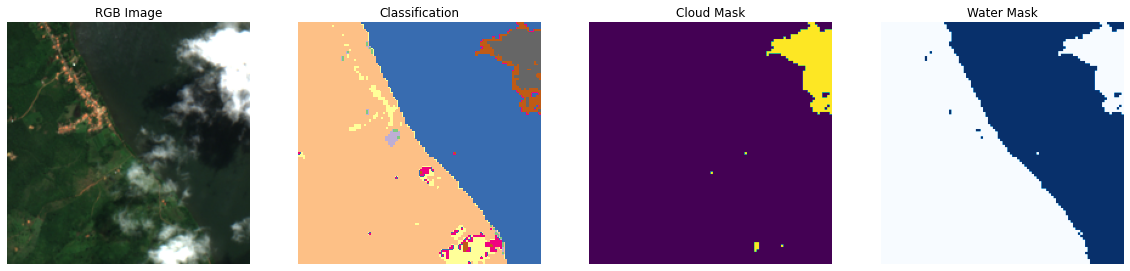

In [57]:
ds.station[station].visualize_chip(19)

In [ ]:
#full loop
for station in ds.df['site_no']:
    ds.get_station_data(station)
    ds.station[station].build_catalog()
    

    if ds.station[station].catalog is None:
        print('No matching images! Skipping...')
        continue
    else:
        ds.station[station].get_cloud_filtered_image_df(cloud_thr)
        ds.station[station].merge_image_df_with_samples(day_tolerance)
        ds.station[station].get_reflectances()

In [ ]:
#write methods!
for station in ds.df['site_no']:
    outfilename = f'az://{ds.container}/stations/{station}/{station}_processed.csv'
    ds.station[station].merged_df.to_csv(outfilename,index=False,storage_options=ds.storage_options)
    print('writing chips!')
    ds.station[station].write_tiles_to_blob(working_dirc='/tmp')


In [109]:
np.mean(np.array(img)[water_mask],axis=0)

array([58.03409091, 57.53787879, 36.66287879])

rasterio gives us data band-interleave format; transpose to pixel interleave, and downscale the image data for plotting. Given the bounds, we will select the a nxn image around our point of interest